# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import tensorflow as tf

# TODO: Fill this in based on where you saved the training and testing data

training_file = "./data/train.p"
testing_file = "./data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X, y = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = X.shape[0]

# TODO: Number of testing examples.
n_test = X.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X.shape[1], X.shape[2])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 39209
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import seaborn as sns
# Visualizations will be shown in the notebook.
%matplotlib inline

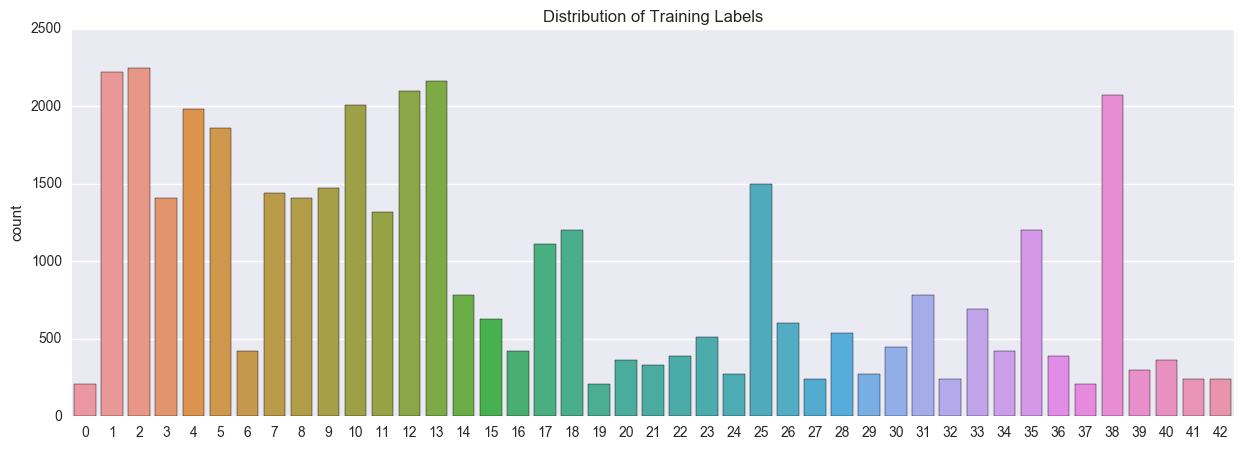

In [4]:
plt.figure(figsize=(15,5))
sns.countplot(y)
plt.title("Distribution of Training Labels")

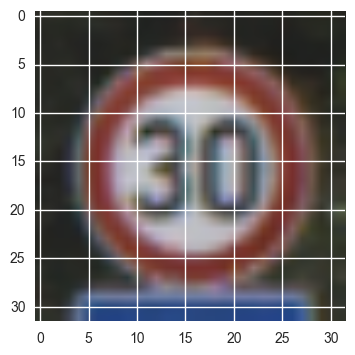

In [5]:
plt.imshow(X[500])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import cv2

def convert_to_yuv(images):
    images_y = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2YUV) for img in images])
    return images_y

def norm_images(images):
    return np.multiply(images, 1.0 / 255.0)

def preprocess_images(images):
    return norm_images(convert_to_yuv(images))

X_pre = preprocess_images(X)
X_test_pre = preprocess_images(X_test)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I preprocessed the data by converting the images to YUV. I then normalized the pixel data to be between 1 and 0 by dividing all the values by 255. I choose these techniques based on the "Traffic Sign Recognition with Multi-Scale Convolutional Networks" as these seemed to work well as preprocessing steps. Also, I new it would be important to normalize the data to help gradient descent perform better.

In [7]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

def rescale(img):
    scale_factor = np.random.uniform(.9, 1.1)
    if scale_factor > 1:
        inter_type = cv2.INTER_LINEAR
    else:
        inter_type = cv2.INTER_AREA
    return cv2.resize(img,None,fx=scale_factor, fy=scale_factor, interpolation = inter_type)

def rotate(img):
    rows,cols,_ = img.shape
    rotate_factor = np.random.uniform(-15.0, 15.0)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),rotate_factor,1)
    return cv2.warpAffine(img,M,(cols,rows))

def translate(img):
    rows,cols,_ = img.shape
    x_translate_factor = np.random.uniform(-2.0, 2.0)
    y_translate_factor = np.random.uniform(-2.0, 2.0)
    M = np.float32([[1,0,x_translate_factor],[0,1,y_translate_factor]])
    return cv2.warpAffine(img,M,(cols,rows))

def jitter_data(data, labels, scale=5):
    assert data.shape[0] == labels.shape[0]
    shape = data.shape
    jitter_data = np.zeros((shape[0]*scale,shape[1],shape[2],shape[3]))
    jitter_labels = np.zeros(shape[0]*scale)
    for n in range(scale):
        start_index = n * shape[0]
        for i in range(shape[0]):
            img = rescale(data[i,:,:,:])
            img = rotate(img)
            img = translate(img)
            row, col, _ = img.shape
            if row > 32:
                inter_type = cv2.INTER_LINEAR
            else:
                inter_type = cv2.INTER_AREA
            img = cv2.resize(img,(32, 32), interpolation = inter_type)
            jitter_data[start_index+i,:,:,:] = img
            jitter_labels[start_index+i] = labels[i]
    return jitter_data, jitter_labels

In [8]:
X_train_jitter, y_train_jitter = jitter_data(X_pre, y, scale=3)
X_train_all = np.concatenate((X_train_jitter, X_pre), axis=0)
y_train_all = np.append(y_train_jitter, y)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_train, X_validation, y_train, y_validation = train_test_split(X_train_all, y_train_all, test_size=0.20, random_state=42)
X_train, y_train = shuffle(X_train, y_train)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I left the testing set as was given to us and split the training data into training and validation. To do this I used scikit learn's train test split functionality using 20% for the validation set and 80% for the training set.

I generated data in the same way as, "Traffic Sign Recognition with Multi-Scale Convolutional Networks." I created 3 extra versions of each image by slightly perturbing the scale, rotation, and translation of the image. I generated the data because adding some distortion to our training data will help our model be more robust.

In [10]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

def conv_layer(x, shape, strides, padding, mean, stddev):
    W = tf.Variable(tf.truncated_normal(shape, mean=mean, stddev=stddev))
    b = tf.Variable(tf.zeros(shape[-1]))
    conv = tf.nn.conv2d(x, W, strides=strides, padding=padding) + b
    return tf.nn.relu(conv)


def fully_connected(x, shape, mu, sigma, actiavation=True):
    W = tf.Variable(tf.truncated_normal(shape, mean=mu, stddev=sigma))
    b = tf.Variable(tf.zeros(shape[-1]))
    fc = tf.matmul(x, W) + b
    if actiavation:
        return tf.nn.relu(fc)
    else:
        return fc
    

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    padding = 'VALID'
    
    conv1 = conv_layer(x, (5,5,3,6), [1,1,1,1], padding, mu, sigma)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=padding)

    conv2 = conv_layer(conv1, (5,5,6,16), [1,1,1,1], padding, mu, sigma)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    fc0   = flatten(conv2)
    fc1   = fully_connected(fc0, (400, 120), mu, sigma)
    fc2   = fully_connected(fc1, (120, 84), mu, sigma)
    return fully_connected(fc2, (84, 43), mu, sigma, False)


def alex_net(x):
    # Hyperparameters
    mu = 0
    sigma = 0.1
    padding = 'VALID'
    
    layer_1 = conv_layer(x, (4,4,3,14), [1,1,1,1], padding, mu, sigma)
    layer_1 = tf.nn.max_pool(layer_1, [1,2,2,1], [1,2,2,1], padding=padding)
    #layer_1 = tf.nn.local_response_normalization(layer_1)
    
    layer_2 = conv_layer(layer_1, (2,2,14,38), [1,1,1,1], padding, mu, sigma)
    layer_2 = tf.nn.max_pool(layer_2, [1,2,2,1], [1,2,2,1], padding=padding)
    #layer_2 = tf.nn.local_response_normalization(layer_2)
    
    #layer_3 = conv_layer(layer_2, (2,2,38,57), [1,1,1,1], padding, mu, sigma)
    #layer_4 = conv_layer(layer_3, (2,2,57,57), [1,1,1,1], padding, mu, sigma)
    
    layer_5 = conv_layer(layer_2, (2,2,38,38), [1,1,1,1], padding, mu, sigma)
    layer_5 = tf.nn.max_pool(layer_5, [1,2,2,1], [1,2,2,1], padding=padding)
    #layer_5 = tf.nn.local_response_normalization(layer_5)

    fc0 = flatten(layer_5)
    network_shape = (fc0.get_shape().as_list()[-1], 4096)
    
    fc1 = fully_connected(fc0, network_shape, mu, sigma)
    fc1 = tf.nn.dropout(fc1, dropout_keep_prob)
    
    fc2 = fully_connected(fc1, (4096,4096), mu, sigma)
    fc2 = tf.nn.dropout(fc2, dropout_keep_prob)
    
    return fully_connected(fc2, (4096, 43), mu, sigma, False)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I modeled my final architecture off of [AlexNet](http://vision.stanford.edu/teaching/cs231b_spring1415/slides/alexnet_tugce_kyunghee.pdf). It is not exactly the same, but I used most of the architecture is a scaled down manner.

I start with a 14 layer deep convolutional layer with relu activation and then max pooling. I then perform local response normalization which treats each channel as a 1-D vector and then divides each component by the weighted sum of squares within a radius of 5. The point of this is to boost neurons with relatively high activations and was shown to improve performance in the AlexNet paper.

I then repeat this process again, but with a depth of 38 on the convolutional layer. I then perform 2 convolutional layers with relu activation - both with a depth of 57.

Then I have another convolutional, relu, max pooling, and local response normalization section with a depth of 38 on the convolutional layer.

I then flatten to a fully connected layer of size 4096 and relu activation followed by drop out with a 50% probability. I repeat this layer again and then output the logits.

In [11]:
x_tf = tf.placeholder(tf.float32, (None, 32, 32, 3))
y_tf = tf.placeholder(tf.int32, (None))
dropout_keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y_tf, 43)

rate = 0.001

logits = alex_net(x_tf)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [12]:
def evaluate(X_data, y_data, BATCH_SIZE):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x_tf: batch_x, y_tf: batch_y, dropout_keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [13]:
EPOCHS = 50
BATCH_SIZE = 128
DROP_PROB = 0.5
SAVE_FILE = 'alex_net'
train = False

if train:
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        print("Training...")
        print()
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x_tf: batch_x, y_tf: batch_y, dropout_keep_prob: DROP_PROB})

            validation_accuracy = evaluate(X_validation, y_validation, BATCH_SIZE)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()

        saver.save(sess, SAVE_FILE)
        print("Model saved")

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used the Adam optimizer with a learning rate of 0.001. I used a batch size of 128 and 100 epochs. I also initialized my weights using a truncated normal with mu = 0 and sigma = 0.1. Lastly, I used padding = 'VALID.'

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

My approach was fairly straight forward. I stared with the implementation of LeNet from a previous lab to make sure I could get the model working as expected. Once I had LeNet working on the traffic sign data, I took a look at some of the [other popular convolutional architectures](http://cs231n.github.io/convolutional-networks/#architectures). After AlexNet and ZFNet, the architectures seemed to become too deep and complicated to implement easily in TensorFlow, so I settled on AlexNet. In order to train the network faster, I scaled down the depth of the convolutional layers of AlexNet. I think AlexNet was suitable for the current problem because it performed very well on ImageNet and was still manageable for me to implement.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [14]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('alex_net.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    test_accuracy = evaluate(X_test_pre, y_test, 128)
    print("Test accuracy: {}".format(test_accuracy))

Test accuracy: 0.9395091051538125


In [15]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

def read_images(file):
    img = cv2.imread(file)
    return cv2.resize(img,(32, 32), interpolation = cv2.INTER_AREA )

sign_0 = read_images("./data/signs/sign_0.jpeg")
sign_1 = read_images("./data/signs/sign_1.jpeg")
sign_2 = read_images("./data/signs/sign_2.jpeg")
sign_3 = read_images("./data/signs/sign_3.jpeg")
sign_4 = read_images("./data/signs/sign_4.jpeg")

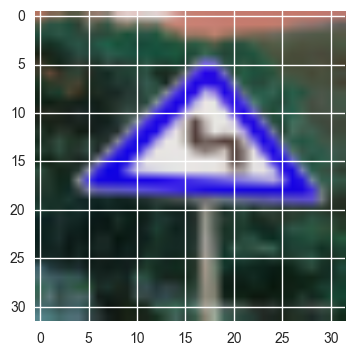

In [16]:
plt.imshow(sign_4)

In [17]:
sign_batch = preprocess_images(np.stack([sign_0, sign_1, sign_2, sign_3, sign_4], 0))
sign_truth = [34, 31, 4, 25, 21]

In [18]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('alex_net.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    sign_accuracy = evaluate(sign_batch, sign_truth, 5)
    sign_predictions = sess.run(tf.argmax(logits, 1), feed_dict={x_tf: sign_batch, y_tf: sign_truth, dropout_keep_prob: 1})
    top_5 = sess.run(tf.nn.top_k(tf.nn.softmax(logits), 5), feed_dict={x_tf: sign_batch, y_tf: sign_truth, dropout_keep_prob: 1})
    print("Sign accuracy: {}".format(sign_accuracy))

Sign accuracy: 0.20000000298023224


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [19]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [20]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [21]:
import pandas as pd

In [22]:
def get_top_5_dict(probabilities, classes, class_map):
    top_5_dict = {}
    for i in range(len(probabilities)):
        key = class_map[class_map.ClassId == classes[i]].SignName.values[0]
        top_5_dict[key] = probabilities[i]
    return top_5_dict

In [23]:
class_map = pd.read_csv("signnames.csv")

In [24]:
class_map[class_map.ClassId == 5].SignName.values[0]

'Speed limit (80km/h)'

In [32]:
get_top_5_dict(top_5[0][4], top_5[1][4], class_map)

{'Bumpy road': 0.00016259185,
 'Go straight or right': 0.0045781741,
 'Keep right': 0.00082511129,
 'Priority road': 9.3748587e-10,
 'Turn left ahead': 0.99443418}

In [26]:
sum(top_5[0][1])

1.0000000087679237

In [27]:
sign_predictions

array([25, 11, 13, 25, 34])

In [28]:
top_5

TopKV2(values=array([[  7.47555852e-01,   2.42581531e-01,   9.86254867e-03,
          6.31420960e-08,   4.01848242e-11],
       [  1.00000000e+00,   8.76792239e-09,   1.40182132e-15,
          1.46377964e-18,   8.73009727e-19],
       [  8.10235202e-01,   1.87990710e-01,   1.21633138e-03,
          2.95370002e-04,   2.08597921e-04],
       [  9.86317098e-01,   1.02151698e-02,   2.96532130e-03,
          4.21650504e-04,   7.84068980e-05],
       [  9.94434178e-01,   4.57817409e-03,   8.25111289e-04,
          1.62591852e-04,   9.37485867e-10]], dtype=float32), indices=array([[25, 17, 12, 26, 23],
       [11, 37, 35, 27, 23],
       [13, 25, 12, 36, 38],
       [25, 37, 38, 33,  0],
       [34, 36, 38, 22, 12]], dtype=int32))